In [24]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from math import nan
import sys
import xesmf as xe

from smyleutils import mapplot_utils as mymaps
from smyleutils import averaging_utils as avg
from smyleutils import bootstrap_utils as boot
from smyleutils import histoplot_utils as histo
from smyleutils import colorbar_utils as cbars
import cartopy.crs as ccrs
import importlib
importlib.reload(avg)
importlib.reload(boot)

<module 'smyleutils.bootstrap_utils' from '/home/islas/python/NCAR_CW3E_SMYLE/smyleutils/bootstrap_utils.py'>

In [2]:
ystart=1979 ; yend=2020

In [3]:
plotpath="/project/cas/islas/python_plots/NCAR_CW3E_SMYLE/FIGURES/"

### Zonal mean zonal wind

In [4]:
basepath="/project/cas/islas/python_savs/NCAR_CW3E_SMYLE/DATA_SORT/Uzm/"
uzm_obs = xr.open_dataset(basepath+"Uzm_ERA5_day_init11.nc").Uzm.sel(time=slice("1970-12-01","1971-02-28")).mean('time')
uzm_l83 = xr.open_dataset(basepath+"Uzm_BSMYLE-CW3E-L83_day_init11.nc").Uzm.sel(time=slice("1970-12-01","1971-02-28")).mean('time')
uzm_l32 = xr.open_dataset(basepath+"Uzm_BSMYLE-CW3E_day_init11.nc").Uzm.sel(time=slice("1970-12-01","1971-02-28")).mean('time')

In [5]:
# 5S-5N at 50hPa
qbo_obs = avg.cosweightlat(uzm_obs, -5, 5)
qbo_l83 = avg.cosweightlat(uzm_l83, -5, 5)
qbo_l32 = avg.cosweightlat(uzm_l32, -5, 5)

qbo_obs = qbo_obs.interp(level=50.)
qbo_l83 = qbo_l83.interp(ilev=50.)
qbo_l32 = qbo_l32.interp(ilev=50.)

DataArrayWeighted with weights along dimensions: lat
DataArrayWeighted with weights along dimensions: lat
DataArrayWeighted with weights along dimensions: lat


### MJO filtered OLR

In [6]:
basepath="/project/cas/islas/python_savs/NCAR_CW3E_SMYLE/DATA_SORT/MJO_OLR/"
mjo_obs = xr.open_dataset(basepath+"MJOfilteredOLR_ERA5_init11.nc").std('time').sel(lat=slice(-40,40))
mjo_l83 = xr.open_dataset(basepath+"MJOfilteredOLR_SMYLE_L83_init11.nc")
mjo_l83['init_year'] = np.arange(1970,2020+1,1)
mjo_l32 = xr.open_dataset(basepath+"MJOfilteredOLR_SMYLE_L32_init11.nc")
mjo_l32['init_year'] = np.arange(1970,2020+1,1)

### SST 

In [7]:
basepath="/project/cas/islas/python_savs/NCAR_CW3E_SMYLE/DATA_SORT/SST/"
sst_obs = xr.open_dataset(basepath+"SST_ERSSTv5_mon_init11.nc").mean('time')
sst_l83 = xr.open_dataset(basepath+"SST_BSMYLE-CW3E-L83_mon_init11.nc").sel(time=slice("1970-12-01","1971-02-28")).mean('time')-273.15
sst_l32 = xr.open_dataset(basepath+"SST_BSMYLE-CW3E-L32_mon_init11.nc").sel(time=slice("1970-12-01","1971-02-28")).mean('time')-273.15

### Get them all on the same grid

In [8]:
grid = xr.Dataset({'lat':(['lat'], mjo_obs.lat.values)}, {'lon':(['lon'], mjo_obs.lon.values)})
regridder = xe.Regridder(sst_obs, grid, 'bilinear', periodic=True, reuse_weights=False,
                         filename='/project/cas/islas/temp/wgt.nc')
sst_obs = regridder(sst_obs.sst)

sst_obs = sst_obs.sel(lat=slice(-40,40))
sst_l83 = sst_l83.sel(lat=slice(-40,40))
sst_l32 = sst_l32.sel(lat=slice(-40,40))

sst_l83['lon'] = grid.lon ; sst_l83['lat'] = grid.lat
sst_l32['lon'] = grid.lon ; sst_l32['lat'] = grid.lat
mjo_l83['lon'] = grid.lon ; mjo_l83['lat'] = grid.lat
mjo_l32['lon'] = grid.lon ; mjo_l32['lat'] = grid.lat
mjo_obs['lon'] = grid.lon ; mjo_obs['lat'] = grid.lat

### Grab out the same time period

In [9]:
qbo_obs = qbo_obs.sel(init_year=slice(ystart,yend))
sst_obs = sst_obs.sel(init_year=slice(ystart,yend))
mjo_obs = mjo_obs.sel(init_year=slice(ystart,yend))

qbo_l83 = qbo_l83.sel(init_year=slice(ystart,yend))
sst_l83 = sst_l83.sel(init_year=slice(ystart,yend))
mjo_l83 = mjo_l83.sel(init_year=slice(ystart,yend))

qbo_l32 = qbo_l32.sel(init_year=slice(ystart,yend))
sst_l32 = sst_l32.sel(init_year=slice(ystart,yend))
mjo_l32 = mjo_l32.sel(init_year=slice(ystart,yend))

### Composite QBO westerly and easterly

In [10]:
# compositing westerly and easterly QBO
# defining the QBO phase based on the anomalies from the climatological average
# westerly QBO is where the qbo winds are greater than 0.5 times the interannual standard deviation
# easterly QBO is where the qbo winds are less than -0.5 times the interannual standard deviation
def composite_w_e(qbo, sst, mjo, timevar='init_year'):
    qbo = qbo - qbo.mean(timevar)
    sst = sst - sst.mean(timevar)
    mjo = mjo - mjo.mean(timevar)
    
    qbo_w = qbo.where(qbo > 0.5*qbo.std(timevar), nan).mean(timevar, skipna=True).rename('u_w')
    qbo_e = qbo.where(qbo < -0.5*qbo.std(timevar), nan).mean(timevar, skipna=True).rename('u_e')
    sst_w = sst.where(qbo > 0.5*qbo.std(timevar), nan).mean(timevar, skipna=True).rename('sst_w')
    sst_e = sst.where(qbo < -0.5*qbo.std(timevar), nan).mean(timevar, skipna=True).rename('sst_e')
    mjo_w = mjo.where(qbo > 0.5*qbo.std(timevar), nan).mean(timevar, skipna=True).rename('mjo_w')
    mjo_e = mjo.where(qbo < -0.5*qbo.std(timevar), nan).mean(timevar, skipna=True).rename('mjo_e')
    
    datout = xr.merge([qbo_w, qbo_e, sst_w, sst_e, mjo_w, mjo_e])
    return datout

In [11]:
#---Compositing based on the observed QBO
obs_comp = composite_w_e(qbo_obs, sst_obs, mjo_obs.MJO_OLR)
l83_comp = composite_w_e(qbo_obs, sst_l83.TS, mjo_l83.MJO_OLR)
l32_comp = composite_w_e(qbo_obs, sst_l32.TS, mjo_l32.MJO_OLR)

In [12]:
mjo_obs_region = avg.cosweightlonlat(mjo_obs.MJO_OLR, 50, 170, -20, 5)
mjo_l83_region = avg.cosweightlonlat(mjo_l83.MJO_OLR, 50, 170, -20, 5)
mjo_l32_region = avg.cosweightlonlat(mjo_l32.MJO_OLR, 50, 170, -20, 5)

sst_obs_region = avg.cosweightlonlat(sst_obs, 190, 240, -5, 5)
sst_l83_region = avg.cosweightlonlat(sst_l83, 190, 240, -5, 5)
sst_l32_region = avg.cosweightlonlat(sst_l32, 190, 240, -5, 5)

In [ ]:
# Bootstrapping members for each year and stringing together.
boot_mjo_l83 = [] ; boot_sst_l83 = [] ; boot_qbo_l83 = []
boot_mjo_l32 = [] ; boot_sst_l32 = [] ; boot_qbo_l32 = []
for iyear in np.arange(0,mjo_obs.init_year.size,1):
    boot_mjo = boot.bootgen(mjo_l83_region.isel(init_year=iyear), nsamples=1, seed=iyear).isel(isample=0)
    boot_sst = boot.bootgen(sst_l83_region.TS.isel(init_year=iyear), nsamples=1, seed=iyear).isel(isample=0)
    boot_qbo = boot.bootgen(qbo_l83.isel(init_year=iyear), nsamples=1, seed=iyear).isel(isample=0)
    boot_mjo_l83.append(boot_mjo)
    boot_sst_l83.append(boot_sst)
    boot_qbo_l83.append(boot_qbo)
    
    boot_mjo = boot.bootgen(mjo_l32_region.isel(init_year=iyear), nsamples=1, seed=iyear).isel(isample=0)
    boot_sst = boot.bootgen(sst_l32_region.TS.isel(init_year=iyear), nsamples=1, seed=iyear).isel(isample=0)
    boot_qbo = boot.bootgen(qbo_l32.isel(init_year=iyear), nsamples=1, seed=iyear).isel(isample=0)
    boot_mjo_l32.append(boot_mjo)
    boot_sst_l32.append(boot_sst)
    boot_qbo_l32.append(boot_qbo)     
    
boot_mjo_l83 = xr.concat(boot_mjo_l83, dim=mjo_obs.init_year)
boot_sst_l83 = xr.concat(boot_sst_l83, dim=mjo_obs.init_year)
boot_qbo_l83 = xr.concat(boot_qbo_l83, dim=mjo_obs.init_year)

boot_mjo_l32 = xr.concat(boot_mjo_l32, dim=mjo_obs.init_year)
boot_sst_l32 = xr.concat(boot_sst_l32, dim=mjo_obs.init_year)
boot_qbo_l32 = xr.concat(boot_qbo_l32, dim=mjo_obs.init_year)

In [14]:
boot_qbo_obs = xr.DataArray(np.zeros([boot_qbo_l83.init_year.size, boot_qbo_l83.iboot.size]), dims=['init_year','iboot'], 
                            coords=[boot_qbo_l83.init_year, boot_qbo_l83.iboot], name='boot_qbo_obs')
boot_qbo_obs[:,:] = qbo_obs

In [15]:
# composites for regions
bootcomp_l83 = composite_w_e(boot_qbo_obs, boot_sst_l83, boot_mjo_l83)
bootcomp_l32 = composite_w_e(boot_qbo_obs, boot_sst_l32, boot_mjo_l32)
compregions_obs = composite_w_e(qbo_obs, sst_obs_region, mjo_obs_region)
compregions_l83 = composite_w_e(qbo_obs, sst_l83_region.TS, mjo_l83_region)
compregions_l32 = composite_w_e(qbo_obs, sst_l32_region.TS, mjo_l32_region)

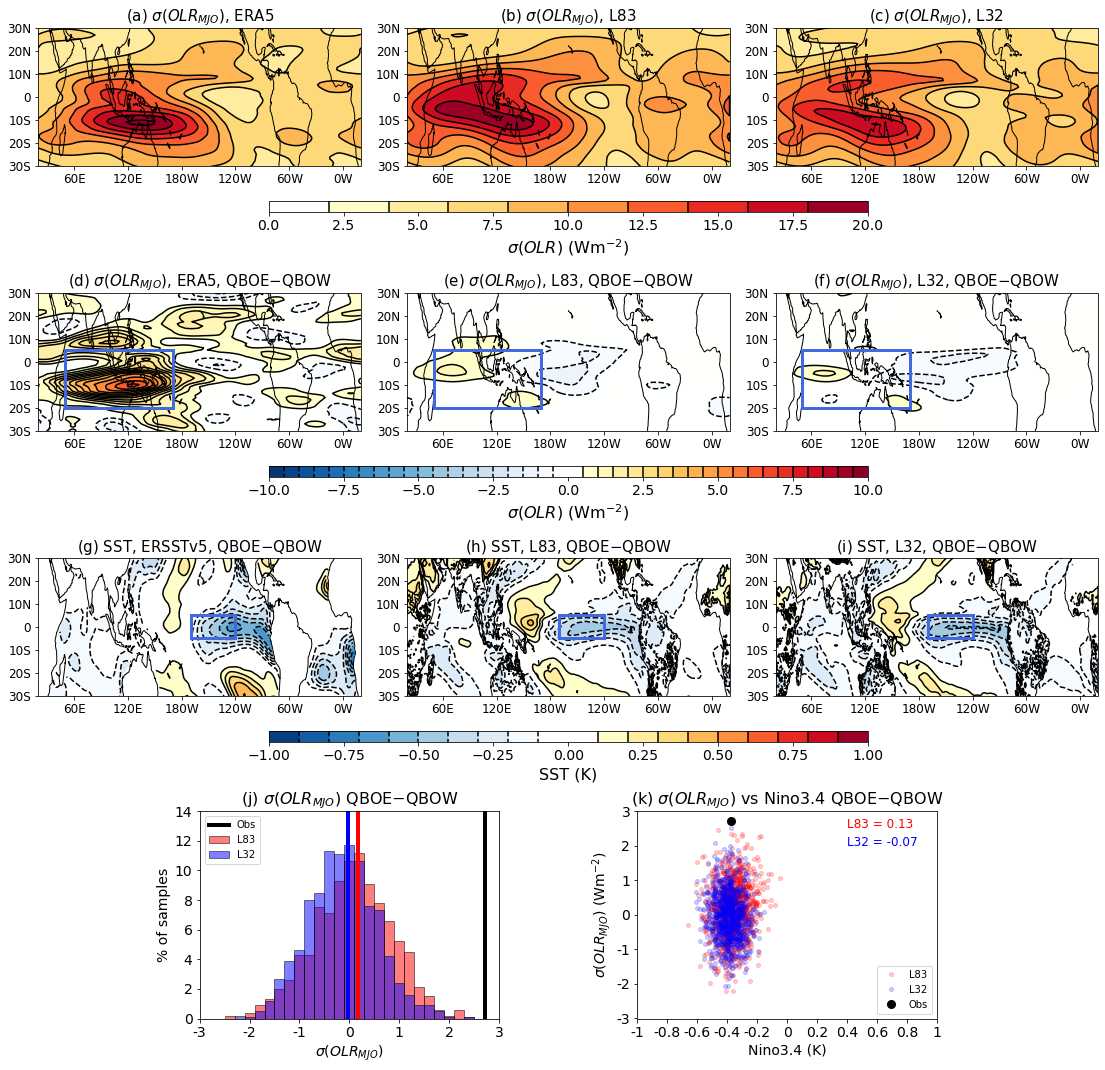

In [32]:
fig = plt.figure(figsize=(16,16))


ci=2 ; cmax=20
ax = mymaps.contourmap_bothoceans_tropics_fill_pos(fig, mjo_obs.MJO_OLR.mean('init_year'),
                                                   mjo_obs.lon, mjo_obs.lat, ci, -1.*cmax, cmax,
                                                   '(a) $\sigma(OLR_{MJO})$, ERA5', 
                                                   0.02,0.3,0.9,1.02, contourlines=True)

ax = mymaps.contourmap_bothoceans_tropics_fill_pos(fig, mjo_l83.MJO_OLR.mean(['init_year','M']),
                                                   mjo_l83.lon, mjo_l83.lat, ci, -1.*cmax, cmax,
                                                   '(b) $\sigma(OLR_{MJO})$, L83',
                                                   0.34,0.62,0.9,1.02, contourlines=True)

ax = mymaps.contourmap_bothoceans_tropics_fill_pos(fig, mjo_l32.MJO_OLR.mean(['init_year','M']),
                                                   mjo_l32.lon, mjo_l32.lat, ci, -1.*cmax, cmax,
                                                   '(c) $\sigma(OLR_{MJO})$, L32',
                                                   0.66,0.94,0.9,1.02, contourlines=True)

ax = cbars.plotcolorbar(fig, ci, -1.*cmax, cmax, '$\sigma(OLR)$ (Wm$^{-2}$)',
                        0.22,0.74,0.86,0.87,contourlines=True, posneg='pos')



ci = 0.5 ; cmax = 10

ax = mymaps.contourmap_bothoceans_tropics_fill_pos(fig, obs_comp.mjo_e - obs_comp.mjo_w ,
                                                   obs_comp.lon, obs_comp.lat, ci, -1.*cmax, cmax,
                                                   '(d) $\sigma(OLR_{MJO})$, ERA5, QBOE$-$QBOW',0.02,0.3,0.67,0.79,contourlines=True)
ax.plot([50,170],[-20,-20], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)
ax.plot([50,170],[5,5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)
ax.plot([50,50],[-20,5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)
ax.plot([170,170],[-20,5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)


ax = mymaps.contourmap_bothoceans_tropics_fill_pos(fig, l83_comp.mjo_e.mean('M') - l83_comp.mjo_w.mean('M'),
                                                   l83_comp.lon, l83_comp.lat, ci, -1.*cmax, cmax,
                                                   '(e) $\sigma(OLR_{MJO})$, L83, QBOE$-$QBOW',0.34,0.62,0.67,0.79, contourlines=True)
ax.plot([50,170],[-20,-20], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)
ax.plot([50,170],[5,5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)
ax.plot([50,50],[-20,5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)
ax.plot([170,170],[-20,5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)


ax = mymaps.contourmap_bothoceans_tropics_fill_pos(fig, l32_comp.mjo_e.mean('M') - l32_comp.mjo_w.mean('M'),
                                                   l32_comp.lon, l32_comp.lat, ci, -1.*cmax, cmax,
                                                   '(f) $\sigma(OLR_{MJO})$, L32, QBOE$-$QBOW',0.66,0.94,0.67,0.79, contourlines=True)
ax.plot([50,170],[-20,-20], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)
ax.plot([50,170],[5,5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)
ax.plot([50,50],[-20,5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)
ax.plot([170,170],[-20,5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)

ax = cbars.plotcolorbar(fig, ci, -1.*cmax, cmax, '$\sigma(OLR)$ (Wm$^{-2}$)',
                        0.22,0.74,0.63,0.64,contourlines=True)




ci=0.1 ; cmax=1

ax = mymaps.contourmap_bothoceans_tropics_fill_pos(fig, obs_comp.sst_e - obs_comp.sst_w,
                                                   obs_comp.lon, obs_comp.lat, ci, -1.*cmax, cmax,
                                                   '(g) SST, ERSSTv5, QBOE$-$QBOW',
                                                   0.02,0.3,0.44,0.56, contourlines=True)
ax.plot([190,240],[-5,-5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)
ax.plot([190,240],[5,5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)
ax.plot([190,190],[-5,5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)
ax.plot([240,240],[-5,5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)


ax = mymaps.contourmap_bothoceans_tropics_fill_pos(fig, l83_comp.sst_e.mean('M') - l83_comp.sst_w.mean('M'),
                                                   l83_comp.lon, l83_comp.lat, ci, -1.*cmax, cmax,
                                                   '(h) SST, L83, QBOE$-$QBOW',
                                                   0.34,0.62,0.44,0.56, contourlines=True)
ax.plot([190,240],[-5,-5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)
ax.plot([190,240],[5,5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)
ax.plot([190,190],[-5,5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)
ax.plot([240,240],[-5,5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)


ax = mymaps.contourmap_bothoceans_tropics_fill_pos(fig, l32_comp.sst_e.mean('M') - l32_comp.sst_w.mean('M'),
                                                   l32_comp.lon, l32_comp.lat, ci, -1.*cmax, cmax,
                                                   '(i) SST, L32, QBOE$-$QBOW',
                                                   0.66,0.94,0.44,0.56, contourlines=True)
ax.plot([190,240],[-5,-5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)
ax.plot([190,240],[5,5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)
ax.plot([190,190],[-5,5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)
ax.plot([240,240],[-5,5], color='royalblue', transform=ccrs.PlateCarree(), linewidth=3)


ax = cbars.plotcolorbar(fig, ci, -1.*cmax, cmax, 'SST (K)',
                        0.22,0.74,0.4,0.41,contourlines=True)



ax = fig.add_axes([0.16,0.16,0.26,0.18])
ax.set_ylim(0,14)
ax.set_yticks([0,2,4,6,8,10,12,14])
ax.set_yticklabels(['0','2','4','6','8','10','12','14'], fontsize=14)
ax.set_xlim(-3,3)
ax.set_xticks([-3,-2,-1,0,1,2,3])
ax.set_xticklabels(['-3','-2','-1','0','1','2','3'], fontsize=14)
ax.set_xlabel('$\sigma(OLR_{MJO})$', fontsize=14)
ax.set_ylabel('% of samples', fontsize=14)
ax.set_title('(j) $\sigma(OLR_{MJO})$ QBOE$-$QBOW', fontsize=16)
ax = histo.oplothisto(ax, bootcomp_l83.mjo_e - bootcomp_l83.mjo_w, np.arange(-3,3,0.2), 
                      percent=True, color='red', alpha=0.5, label='L83')
ax = histo.oplothisto(ax, bootcomp_l32.mjo_e - bootcomp_l32.mjo_w, np.arange(-3,3,0.2),
                      percent=True, color='blue', alpha=0.5, label='L32')
ax.plot([compregions_obs.mjo_e - compregions_obs.mjo_w, 
         compregions_obs.mjo_e - compregions_obs.mjo_w],[0,14], color='black', linewidth=4, label='Obs')
ax.plot([compregions_l83.mjo_e.mean('M') - compregions_l83.mjo_w.mean('M'), 
         compregions_l83.mjo_e.mean('M') - compregions_l83.mjo_w.mean('M')],[0,14], color='red', linewidth=4)
ax.plot([compregions_l32.mjo_e.mean('M') - compregions_l32.mjo_w.mean('M'), 
         compregions_l32.mjo_e.mean('M') - compregions_l32.mjo_w.mean('M')],[0,14], color='blue', linewidth=4)
ax.legend(loc='upper left')



ax = fig.add_axes([0.54,0.16,0.26,0.18])
ax.set_xlim(-1,1)
ax.set_ylim(-3,3)
ax.set_xticks([-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])
ax.set_xticklabels(['-1','-0.8','-0.6','-0.4','-0.2','0','0.2','0.4','0.6','0.8','1'], fontsize=14)
ax.set_yticks([-3,-2,-1,0,1,2,3])
ax.set_yticklabels(['-3','-2','-1','0','1','2','3'], fontsize=14)
ax.set_title('(k) $\sigma(OLR_{MJO})$ vs Nino3.4 QBOE$-$QBOW', fontsize=16)
ax.set_xlabel('Nino3.4 (K)', fontsize=14)
ax.set_ylabel('$\sigma(OLR_{MJO})$ (Wm$^{-2}$)', fontsize=14)

r_l83 = xr.corr(bootcomp_l83.sst_e - bootcomp_l83.sst_w, bootcomp_l83.mjo_e - bootcomp_l83.mjo_w)
r_l32 = xr.corr(bootcomp_l32.sst_e - bootcomp_l32.sst_w, bootcomp_l32.mjo_e - bootcomp_l32.mjo_w)

rboot_l83 = boot.boot_corcoefs(bootcomp_l83.sst_e - bootcomp_l83.sst_w, bootcomp_l83.mjo_e - bootcomp_l83.mjo_w)
rboot_l32 = boot.boot_corcoefs(bootcomp_l32.sst_e - bootcomp_l32.sst_w, bootcomp_l32.mjo_e - bootcomp_l32.mjo_w)

min95_l83 = rboot_l83.quantile(0.025, dim='boot')
max95_l83 = rboot_l83.quantile(0.975, dim='boot')

min95_l32 = rboot_l32.quantile(0.025, dim='boot')
max95_l32 = rboot_l32.quantile(0.975, dim='boot')



ax.plot(bootcomp_l83.sst_e - bootcomp_l83.sst_w, bootcomp_l83.mjo_e - bootcomp_l83.mjo_w,"o", color='red', alpha=0.2, markersize=4,label='L83')
ax.plot(bootcomp_l32.sst_e - bootcomp_l32.sst_w, bootcomp_l32.mjo_e - bootcomp_l32.mjo_w,"o", color='blue', alpha=0.2, markersize=4, label='L32')
ax.plot(compregions_obs.sst_e - compregions_obs.sst_w, compregions_obs.mjo_e - compregions_obs.mjo_w, "o", color='black', markersize=8, label='Obs')

ax.text(0.4,2.5,"L83 = {:.2f}".format(r_l83), color='red', fontsize=12)
ax.text(0.4,2.,"L32 = {:.2f}".format(r_l32), color='blue', fontsize=12)


ax.legend(loc='lower right')

fig.savefig(plotpath+'fig5_mjo.png', bbox_inches='tight', facecolor='white')


In [18]:
r = xr.corr(bootcomp_l83.sst_e - bootcomp_l83.sst_w, bootcomp_l83.mjo_e - bootcomp_l83.mjo_w)

In [21]:
r_l32 = xr.corr(bootcomp_l32.sst_e - bootcomp_l32.sst_w, bootcomp_l32.mjo_e - bootcomp_l32.mjo_w)

In [22]:
dif_l83 = bootcomp_l83.sst_e - bootcomp_l83.sst_w
dif_l83_m = dif_l83.mean('iboot')

dif_l32 = bootcomp_l32.sst_e - bootcomp_l32.sst_w
dif_l32_m = dif_l32.mean('iboot')


In [22]:
r_l32

<xarray.DataArray ()> Size: 8B
array(-0.07032339)
Coordinates:
    isample  int64 8B 0

In [21]:
dif_l83_m

<xarray.DataArray ()> Size: 8B
array(-0.15660248)
Coordinates:
    isample  int64 8B 0

In [88]:
mjo_obs_region = avg.cosweightlonlat(mjo_obs.MJO_OLR, 50, 170, -20, 5)
mjo_l83_region = avg.cosweightlonlat(mjo_l83.MJO_OLR, 50, 170, -20, 5)
mjo_l32_region = avg.cosweightlonlat(mjo_l32.MJO_OLR, 50, 170, -20, 5)

sst_obs_region = avg.cosweightlonlat(sst_obs, 190, 240, -5, 5)
sst_l83_region = avg.cosweightlonlat(sst_l83, 190, 240, -5, 5)
sst_l32_region = avg.cosweightlonlat(sst_l32, 190, 240, -5, 5)

In [ ]:
boot_mjo_l83 = [] ; boot_sst_l83 = [] ; boot_qbo_l83 = []
boot_mjo_l32 = [] ; boot_sst_l32 = [] ; boot_qbo_l32 = []
for iyear in np.arange(0,mjo_obs.init_year.size,1):
    boot_mjo = boot.bootgen(mjo_l83_region.isel(init_year=iyear), nsamples=1, seed=iyear).isel(isample=0)
    boot_sst = boot.bootgen(sst_l83_region.TS.isel(init_year=iyear), nsamples=1, seed=iyear).isel(isample=0)
    boot_qbo = boot.bootgen(qbo_l83.isel(init_year=iyear), nsamples=1, seed=iyear).isel(isample=0)
    boot_mjo_l83.append(boot_mjo)
    boot_sst_l83.append(boot_sst)
    boot_qbo_l83.append(boot_qbo)
    
    boot_mjo = boot.bootgen(mjo_l32_region.isel(init_year=iyear), nsamples=1, seed=iyear).isel(isample=0)
    boot_sst = boot.bootgen(sst_l32_region.TS.isel(init_year=iyear), nsamples=1, seed=iyear).isel(isample=0)
    boot_qbo = boot.bootgen(qbo_l32.isel(init_year=iyear), nsamples=1, seed=iyear).isel(isample=0)
    boot_mjo_l32.append(boot_mjo)
    boot_sst_l32.append(boot_sst)
    boot_qbo_l32.append(boot_qbo)     
    
boot_mjo_l83 = xr.concat(boot_mjo_l83, dim=mjo_obs.init_year)
boot_sst_l83 = xr.concat(boot_sst_l83, dim=mjo_obs.init_year)
boot_qbo_l83 = xr.concat(boot_qbo_l83, dim=mjo_obs.init_year)

boot_mjo_l32 = xr.concat(boot_mjo_l32, dim=mjo_obs.init_year)
boot_sst_l32 = xr.concat(boot_sst_l32, dim=mjo_obs.init_year)
boot_qbo_l32 = xr.concat(boot_qbo_l32, dim=mjo_obs.init_year)


In [110]:
bootcomp_l83 = composite_w_e(boot_qbo_l83, boot_sst_l83, boot_mjo_l83)
bootcomp_l32 = composite_w_e(boot_qbo_l32, boot_sst_l32, boot_mjo_l32)
compregions_obs = composite_w_e(qbo_obs, sst_obs_region, mjo_obs_region)

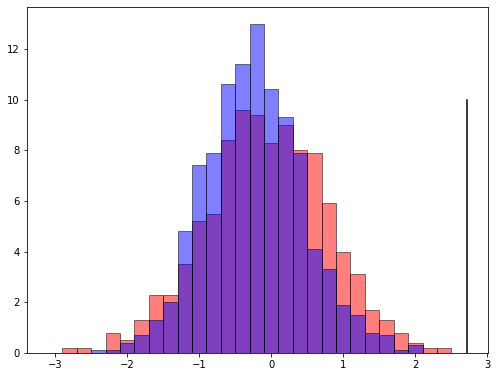

In [133]:
fig = plt.figure(figsize=(16,16))

ax = histo.plothisto(fig, bootcomp_l83.mjo_e - bootcomp_l83.mjo_w, np.arange(-3,3,0.2),0.05,0.45,0.7,1, percent=True, color='red', alpha=0.5)
ax = histo.oplothisto(ax, bootcomp_l32.mjo_e - bootcomp_l32.mjo_w, np.arange(-3,3,0.2),percent=True, color='blue', alpha=0.5)
ax.plot([compregions_obs.mjo_e - compregions_obs.mjo_w, compregions_obs.mjo_e - compregions_obs.mjo_w],
        [0,10], color='black')

#ax = histo.plothisto(fig, bootcomp_l32.mjo_e - bootcomp_l32.mjo_w, np.arange(-3,3,0.2),0.5,0.9,0.7,1, percent=True)
#ax.plot([compregions_obs.mjo_e - compregions_obs.mjo_w, compregions_obs.mjo_e - compregions_obs.mjo_w],
#        [0,10], color='black')

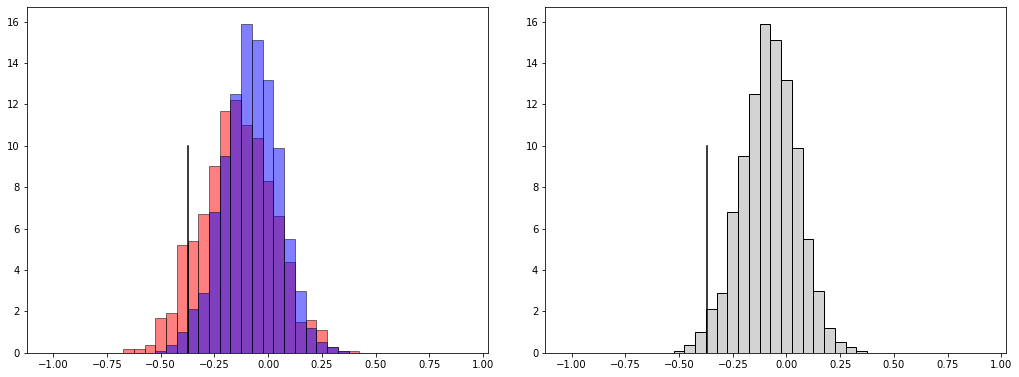

In [132]:
fig = plt.figure(figsize=(16,16))

ax = histo.plothisto(fig, bootcomp_l83.sst_e - bootcomp_l83.sst_w, np.arange(-1,1,0.05),0.05,0.45,0.7,1, percent=True, color='red', alpha=0.5)
ax = histo.oplothisto(ax, bootcomp_l32.sst_e - bootcomp_l32.sst_w, np.arange(-1,1,0.05),percent=True, color='blue', alpha=0.5)
ax.plot([compregions_obs.sst_e - compregions_obs.sst_w, compregions_obs.sst_e - compregions_obs.sst_w],
        [0,10], color='black')

ax = histo.plothisto(fig, bootcomp_l32.sst_e - bootcomp_l32.sst_w, np.arange(-1,1,0.05),0.5,0.9,0.7,1, percent=True)
ax.plot([compregions_obs.sst_e - compregions_obs.sst_w, compregions_obs.sst_e - compregions_obs.sst_w],
        [0,10], color='black')

In [130]:
import importlib
importlib.reload(histo)

<module 'smyleutils.histoplot_utils' from '/home/islas/python/NCAR_CW3E_SMYLE/smyleutils/histoplot_utils.py'>

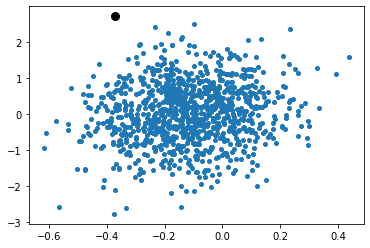

In [124]:
plt.plot(bootcomp_l83.sst_e - bootcomp_l83.sst_w, bootcomp_l83.mjo_e - bootcomp_l83.mjo_w, "o", markersize=4)
#plt.plot(bootcomp_l32.sst_e - bootcomp_l32.sst_w, bootcomp_l32.mjo_e - bootcomp_l32.mjo_w, "o", markersize=4)
plt.plot(compregions_obs.sst_e - compregions_obs.sst_w, compregions_obs.mjo_e - compregions_obs.mjo_w, "o", markersize=8, color='black')

In [125]:
print(xr.corr(bootcomp_l83.sst_e - bootcomp_l83.sst_w, bootcomp_l83.mjo_e - bootcomp_l83.mjo_w))

<xarray.DataArray ()> Size: 8B
array(0.12419056)
Coordinates:
    isample  int64 8B 0


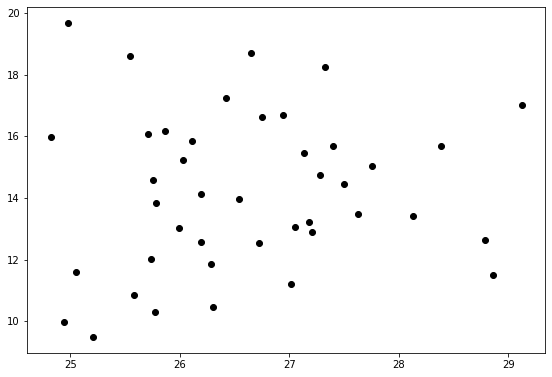

In [89]:
fig = plt.figure(figsize=(16,16))

ax = fig.add_axes([0.05,0.7,0.45,0.3])

ax.plot(sst_obs_region, mjo_obs_region, "o", color='black')

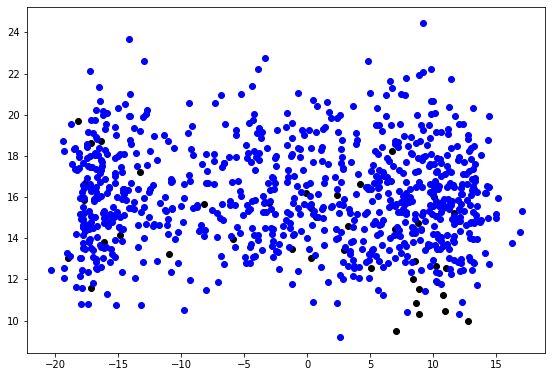

In [87]:
fig = plt.figure(figsize=(16,16))

ax = fig.add_axes([0.05,0.7,0.45,0.3])

ax.plot(qbo_obs, mjo_obs_region, "o", color='black')
for imem in np.arange(0,mjo_l83_region.M.size,1):
    ax.plot(qbo_l83.isel(M=imem), mjo_l83_region.isel(M=imem), "o", color='blue')

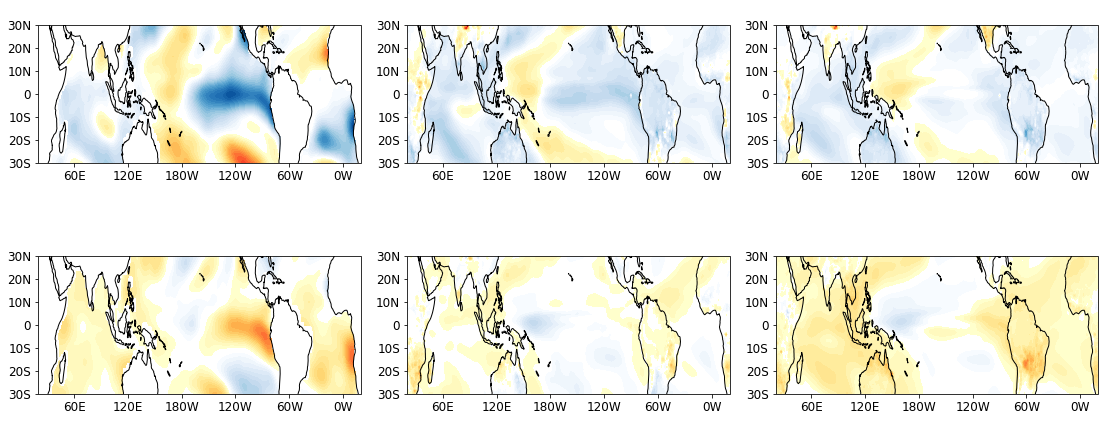

In [73]:
fig = plt.figure(figsize=(16,16))

ci=0.02 ; cmax=0.5
ax = mymaps.contourmap_bothoceans_tropics_fill_pos(fig, obs_comp.sst_e, obs_comp.lon, obs_comp.lat,
                                                   ci, -1.*cmax, cmax, ' ',
                                                   0.02,0.3,0.85,0.97, contourlines=False)

ax = mymaps.contourmap_bothoceans_tropics_fill_pos(fig, l83_comp.sst_e.mean('M'), l83_comp.lon, l83_comp.lat,
                                                   ci, -1.*cmax, cmax, ' ',
                                                   0.34, 0.62, 0.85, 0.97, contourlines=False)

ax = mymaps.contourmap_bothoceans_tropics_fill_pos(fig, l32_comp.sst_e.mean('M'), l32_comp.lon, l32_comp.lat,
                                                   ci, -1.*cmax, cmax,' ',
                                                   0.66,0.94,0.85,0.97, contourlines=False)

ax = mymaps.contourmap_bothoceans_tropics_fill_pos(fig, obs_comp.sst_w, obs_comp.lon, obs_comp.lat,
                                                   ci, -1.*cmax, cmax, ' ',
                                                   0.02,0.3,0.65,0.77, contourlines=False)

ax = mymaps.contourmap_bothoceans_tropics_fill_pos(fig, l83_comp.sst_w.mean('M'), l83_comp.lon, l83_comp.lat,
                                                   ci, -1.*cmax, cmax, ' ',
                                                   0.34, 0.62, 0.65, 0.77, contourlines=False)

ax = mymaps.contourmap_bothoceans_tropics_fill_pos(fig, l32_comp.sst_w.mean('M'), l32_comp.lon, l32_comp.lat,
                                                   ci, -1.*cmax, cmax,' ',
                                                   0.66,0.94,0.65,0.77, contourlines=False)

In [16]:
obs_nino34 = avg.cosweightlonlat(sst_obs, 190, 240, -5, 5)
l83_nino34 = avg.cosweightlonlat(sst_l83, 190, 240, -5, 5)
l32_nino34 = avg.cosweightlonlat(sst_l32, 190, 240, -5, 5)

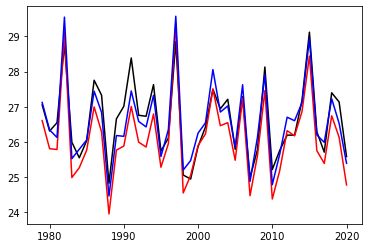

In [17]:
plt.plot(obs_nino34.init_year, obs_nino34, color='black')
plt.plot(l83_nino34.init_year, l83_nino34.TS.mean('M'), color='red')
plt.plot(l32_nino34.init_year, l32_nino34.TS.mean('M'), color='blue')

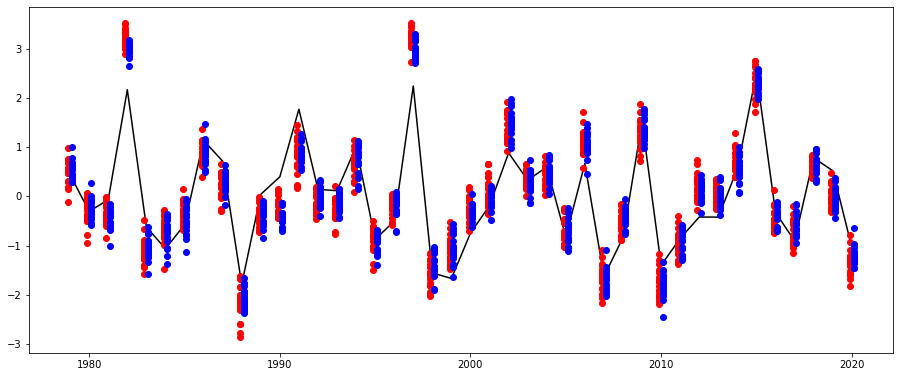

In [17]:
fig = plt.figure(figsize=(16,16))

ax = fig.add_axes([0.05,0.7,0.75,0.3])
ax.plot(obs_nino34.init_year, obs_nino34 - obs_nino34.mean('init_year'), color='black')
for imem in np.arange(0,l83_nino34.M.size,1):
    ax.plot(l83_nino34.init_year-0.1, l83_nino34.TS.isel(M=imem) - l83_nino34.TS.isel(M=imem).mean('init_year'),"o", color='red')
for imem in np.arange(0,l32_nino34.M.size,1):
    ax.plot(l32_nino34.init_year+0.1, l32_nino34.TS.isel(M=imem) - l32_nino34.TS.isel(M=imem).mean('init_year'),"o", color='blue')

In [32]:
for imem in np.arange(0,l83_nino34.M.size,1):
    print(imem,l83_nino34.TS.sel(init_year=1984).isel(M=imem).values)

#print(np.array(l83_nino34.sel(init_year=1982).values))

0 25.482978558201076
1 25.72767563171547
2 25.134762205051626
3 25.645556877966605
4 25.860206810591645
5 25.2751799932157
6 25.227659616815785
7 24.42757959797508
8 25.82793519884908
9 25.594459250533784
10 25.331582654749653
11 25.55566656509879
12 24.618564354419476
13 23.39450872793321
14 25.457388265591337
15 25.39596043309898
16 25.41557050445717
17 25.37259762787849
18 25.014805050456857
19 25.49935887256069


In [24]:
l83_nino34.init_year

<xarray.DataArray 'init_year' (init_year: 42)> Size: 336B
array([1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2020])
Coordinates:
  * init_year  (init_year) int64 336B 1979 1980 1981 1982 ... 2018 2019 2020

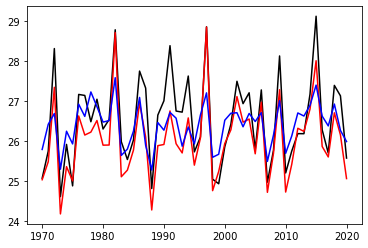

In [71]:
plt.plot(obs_nino34.init_year, obs_nino34, color='black')
plt.plot(l83_nino34.init_year, l83_nino34.TS.mean('M'), color='red')
plt.plot(l32_nino34.init_year, l32_nino34.TS.mean('M'), color='blue')

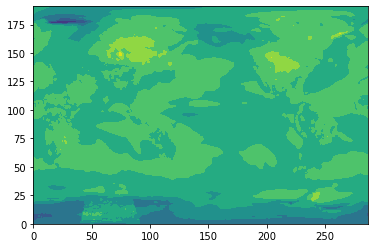

In [54]:
plt.contourf(l83_comp.sst_w.mean('M'))